In [1]:
%load_ext autoreload
%autoreload 2


# Train a model

## Installation

In [1]:
%%bash

pip install graph-pes | tail -n 1

We now should have access to the ``graph-pes-train`` command. We can check this by running:

In [3]:
%%bash

graph-pes-train -h

usage: graph-pes-train [-h] [args ...]

Train a GraphPES model using PyTorch Lightning.

positional arguments:
  args        Config files and command line specifications. Config files
              should be YAML (.yaml/.yml) files. Command line specifications
              should be in the form nested^key=value. Final config is built up
              from these items in a left to right manner, with later items
              taking precedence over earlier ones in the case of conflicts.

optional arguments:
  -h, --help  show this help message and exit

Copyright 2023-24, John Gardner


## Data definition

We use [load-atoms](https://jla-gardner.github.io/load-atoms/) to download and split the C-GAP-17 dataset into training, validation and test datasets:

In [26]:
import ase.io
from load_atoms import load_dataset

structures = load_dataset("C-GAP-17")
train, val, test = structures.random_split([0.8, 0.1, 0.1])

ase.io.write("train-cgap17.xyz", train)
ase.io.write("val-cgap17.xyz", val)
ase.io.write("test-cgap17.xyz", test)

Output()


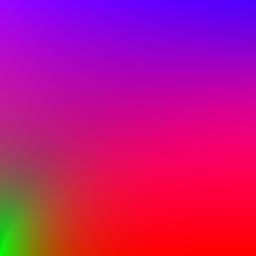

In [3]:
from load_atoms import view

view(train[0], show_bonds=True)

## Configuration

In [20]:
%%bash

if [ ! -f quickstart-cgap17.yaml ]; then
    wget https://raw.githubusercontent.com/jla-gardner/graph-pes/refs/heads/main/docs/source/quickstart/quickstart-cgap17.yaml
fi

## Let's train


You can see the output of this training process in this [Weights and Biases dashboard](https://wandb.ai/jla-gardner/graph-pes-demo/runs/qm7-quickstart).



In [21]:
!rm -rf graph-pes-results
!CUDA_VISIBLE_DEVICES=0 graph-pes-train quickstart-cgap17.yaml

Seed set to 42
[graph-pes INFO]: Set logging level to INFO
[graph-pes INFO]: Started training at 2024-10-29 13:38:35.892
[graph-pes INFO]: Output directory: graph-pes-results/nequip-for-cgap17
[graph-pes INFO]: 
Logging using WandbLogger(
  project="graph-pes-quickstart",
  id="nequip-for-cgap17",
  save_dir="graph-pes-results"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: jla-gardner. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in graph-pes-results/wandb/run-20241029_133836-nequip-for-cgap17
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run nequip-for-cgap17
wandb: ⭐️ View project at https://wandb.ai/jla-gardner/graph-pes-quickstart
wandb: 🚀 View run at https://wandb.ai/jla-gardner/gr

# Model analysis

In [22]:
from graph_pes.models import load_model

best_model = load_model("graph-pes-results/nequip-for-cgap17/model.pt")
best_model


AdditionModel(
  offset=FixedOffset({'C': -148.0}, trainable=False),
  many-body=NequIP(
    (Z_embedding): AtomicOneHot(elements=['C'])
    (initial_node_embedding): PerElementEmbedding(dim=16, elements=['C'])
    (edge_embedding): SphericalHarmonics(1x1o -> 1x0e+1x1o+1x2e)
    (layers): UniformModuleList(
      (0): NequIPMessagePassingLayer(
        (pre_message_linear): Linear(16x0e -> 16x0e | 256 weights)
        (message_tensor_product): TensorProduct(16x0e x 1x0e+1x1o+1x2e -> 16x0e+16x1o+16x2e | 48 paths | 48 weights)
        (weight_generator): HaddamardProduct(
          (components): ModuleList(
            (0): Sequential(
              (0): Bessel(n_features=8, cutoff=3.7, trainable=True)
              (1): MLP(8 → 8 → 8 → 48, activation=SiLU())
            )
            (1): PolynomialEnvelope(cutoff=3.7, p=6)
          )
        )
        (aggregation): SumNeighbours()
        (non_linearity): Gate (28x0e+8x1o+4x2e -> 16x0e+8x1o+4x2e)
        (post_message_linear): Linear

models act on graphs

In [27]:
from graph_pes.atomic_graph import AtomicGraph

test_graphs = [
    AtomicGraph.from_ase(structure, cutoff=3.7) for structure in test
]
test_graphs[0]

AtomicGraph(
    atoms=64,
    edges=1124,
    has_cell=True,
    cutoff=3.7,
    properties=['energy', 'forces']
)

In [28]:
{
    k: v.shape
    for k, v in best_model.get_all_PES_predictions(test_graphs[0]).items()
}


{'energy': torch.Size([]),
 'forces': torch.Size([64, 3]),
 'local_energies': torch.Size([64]),
 'stress': torch.Size([3, 3])}

In [29]:
best_model.predict_energy(test_graphs[0]), test_graphs[0].properties["energy"]

(tensor(-9996.1914, grad_fn=<AddBackward0>), tensor(-9998.7080))

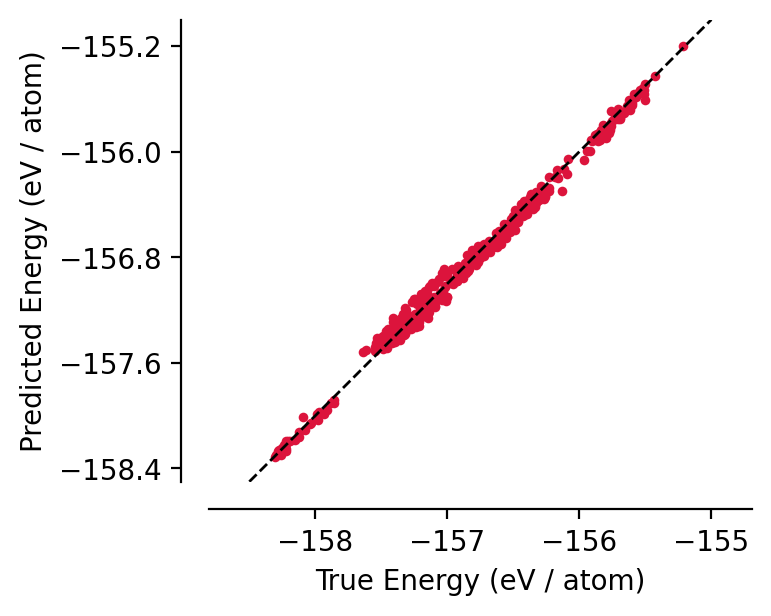

In [30]:
import matplotlib.pyplot as plt

from graph_pes.atomic_graph import divide_per_atom
from graph_pes.utils.analysis import parity_plot

%config InlineBackend.figure_format = 'retina'

parity_plot(
    best_model,
    test_graphs,
    property="energy",
    transform=divide_per_atom,
    units="eV / atom",
    lw=0,
    s=12,
    color="crimson"
)
plt.xlim(-158.5, -155)
plt.ylim(-158.5, -155);


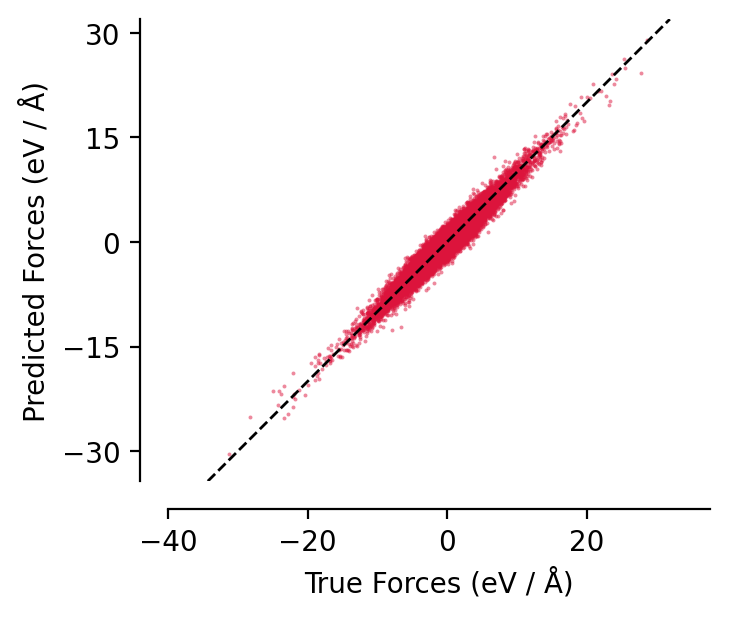

In [31]:
parity_plot(
    best_model,
    test_graphs,
    property="forces",
    units="eV / Å",
    lw=0,
    s=2,
    alpha=0.5,
    color="crimson"
)

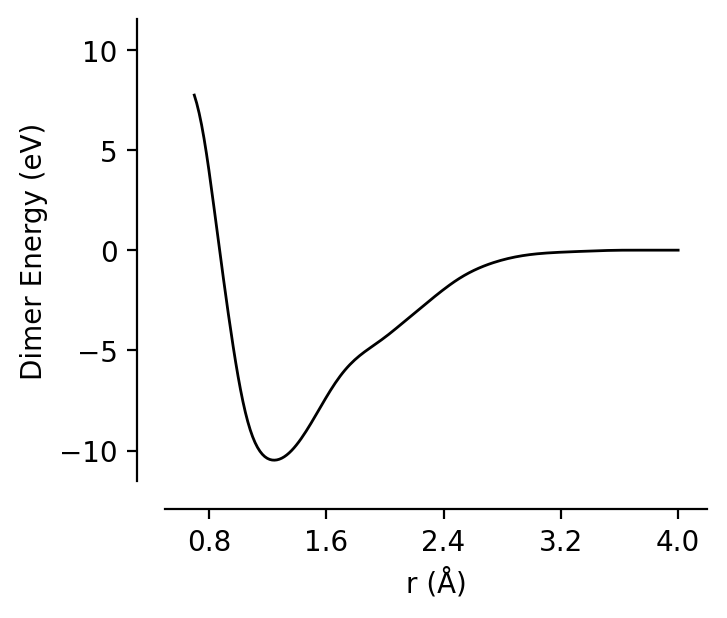

In [33]:
from graph_pes.utils.analysis import dimer_curve

dimer_curve(best_model, system="CC", units="eV", rmin=0.7, rmax=4.0);


# Fine-tuning

In [34]:
import ase.io
from load_atoms import load_dataset

structures = load_dataset("C-GAP-20U")
train, val, test = structures.random_split([0.8, 0.1, 0.1])

ase.io.write("train-cgap20u.xyz", train)
ase.io.write("val-cgap20u.xyz", val)
ase.io.write("test-cgap20u.xyz", test)

Output()

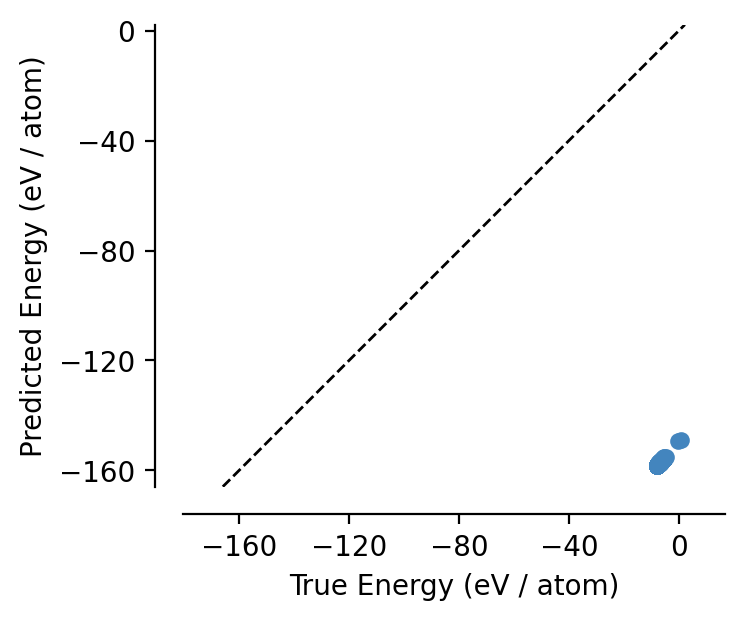

In [35]:
cgap20_test_graphs = [
    AtomicGraph.from_ase(structure, cutoff=3.7) for structure in test
]

parity_plot(
    best_model,
    cgap20_test_graphs,
    property="energy",
    transform=divide_per_atom,
    units="eV / atom",
)

In [36]:
from graph_pes.models import AdditionModel

assert isinstance(best_model, AdditionModel)
underlying_nequip = best_model["many-body"]
type(underlying_nequip)

graph_pes.models.e3nn.nequip.NequIP

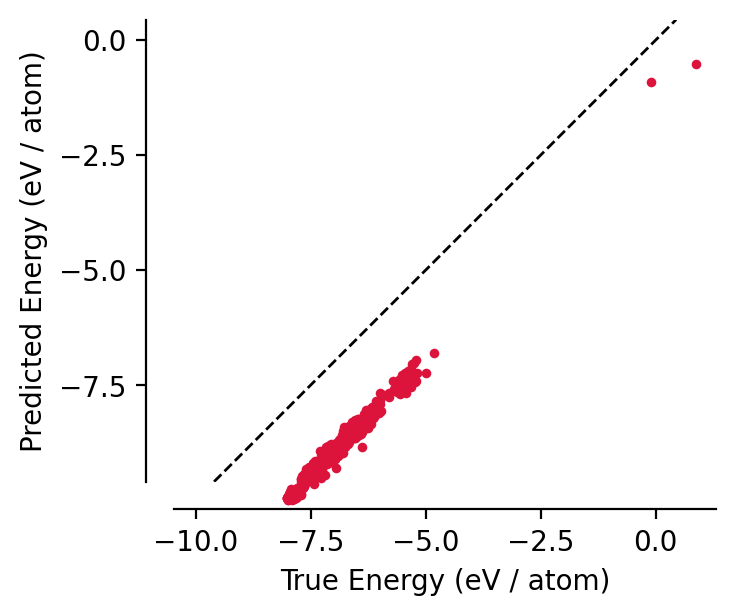

In [43]:
parity_plot(
    underlying_nequip,
    cgap20_test_graphs,
    property="energy",
    transform=divide_per_atom,
    units="eV / atom",
    lw=0,
    s=12,
    color="crimson"
)

In [41]:
%%bash

export CUDA_VISIBLE_DEVICES=0 
graph-pes-train finetune-cgap20u.yaml \
    model^graph_pes.models.load_model_component^path=graph-pes-results/nequip-for-cgap17/model.pt


Seed set to 42


[graph-pes INFO]: Set logging level to INFO
[graph-pes INFO]: Started training at 2024-10-29 13:53:00.598
[graph-pes INFO]: Output directory: graph-pes-results/finetune-nequip-for-cgap20u
[graph-pes INFO]: 
Logging using WandbLogger(
  project="graph-pes-quickstart",
  id="finetune-nequip-for-cgap20u",
  save_dir="graph-pes-results"
)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: jla-gardner. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in graph-pes-results/wandb/run-20241029_135301-finetune-nequip-for-cgap20u
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run finetune-nequip-for-cgap20u
wandb: ⭐️ View project at https://wandb.ai/jla-gardner/graph-pes-quickstart
wandb: 🚀 View run at https://wandb.ai/jla-gardner/graph-pes-quickstart/runs/finetune-nequip-for-cgap20u


[graph-pes INFO]: Logging to graph-pes-results/finetune-nequip-for-cgap20u/logs/rank-0.log
[graph-pes INFO]: 
model:
   graph_pes.models.load_model_component:
      path: graph-pes-results/nequip-for-cgap17/model.pt
      key: many-body
data:
   train:
      graph_pes.data.file_dataset:
         path: train-cgap20u.xyz
         cutoff: 3.7
         n: 1280
         shuffle: false
   valid:
      graph_pes.data.file_dataset:
         path: val-cgap20u.xyz
         cutoff: 3.7
loss:
-  component: graph_pes.training.loss.PerAtomEnergyLoss()
   weight: 1.0
-  component:
      graph_pes.training.loss.Loss:
         property: forces
         metric: RMSE
   weight: 1.0
fitting:
   pre_fit_model: true
   max_n_pre_fit: 5000
   early_stopping_patience: null
   trainer_kwargs:
      max_epochs: 100
      accelerator: auto
      enable_model_summary: false
      check_val_every_n_epoch: 2
   loader_kwargs:
      num_workers: 0
      persistent_workers: false
      batch_size: 64
      pin_memory

/u/vld/jesu2890/miniconda3/envs/graphs/lib/python3.9/site-packages/torch/utils/_contextlib.py:115: UserWarning: This model (NequIP) has already been pre-fitted. This, and any subsequent, call to pre_fit will be ignored.
  return func(*args, **kwargs)


[graph-pes INFO]: 
Model:
NequIP(
  (Z_embedding): AtomicOneHot(elements=['C'])
  (initial_node_embedding): PerElementEmbedding(dim=16, elements=['C'])
  (edge_embedding): SphericalHarmonics(1x1o -> 1x0e+1x1o+1x2e)
  (layers): UniformModuleList(
    (0): NequIPMessagePassingLayer(
      (pre_message_linear): Linear(16x0e -> 16x0e | 256 weights)
      (message_tensor_product): TensorProduct(16x0e x 1x0e+1x1o+1x2e -> 16x0e+16x1o+16x2e | 48 paths | 48 weights)
      (weight_generator): HaddamardProduct(
        (components): ModuleList(
          (0): Sequential(
            (0): Bessel(n_features=8, cutoff=3.7, trainable=True)
            (1): MLP(8 → 8 → 8 → 48, activation=SiLU())
          )
          (1): PolynomialEnvelope(cutoff=3.7, p=6)
        )
      )
      (aggregation): SumNeighbours()
      (non_linearity): Gate (28x0e+8x1o+4x2e -> 16x0e+8x1o+4x2e)
      (post_message_linear): Linear(16x0e+16x1o+16x2e -> 28x0e+8x1o+4x2e | 640 weights)
      (self_interaction): LinearSelfInte

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/u/vld/jesu2890/miniconda3/envs/graphs/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.
/u/vld/jesu2890/miniconda3/envs/graphs/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_w

                            valid/metrics   valid/metrics   timer/its_per_s   timer/its_per_s
   epoch      time   per_atom_energy_rmse     forces_rmse             train             valid
       1       4.1                0.08826         0.70581          26.31579          47.52123
       3       7.3                0.08161         0.68809          25.00000          47.57816
       5      10.6                0.08487         0.68619          32.25806          47.73768
       7      13.9                0.08231         0.68478          26.31579          48.04720
       9      17.3                0.08485         0.68306          21.73913          48.14643
      11      20.6                0.07626         0.68587          25.64103          48.10596
      13      24.0                0.07583         0.68311          26.31579          47.72285
      15      27.3                0.10182         0.68387          27.77778          47.34007
      17      30.7                0.09286         0.67978   

`Trainer.fit` stopped: `max_epochs=100` reached.


[graph-pes INFO]: Loading best weights from "/home/vld-gpu01/vld/jesu2890/graph-pes/docs/source/quickstart/graph-pes-results/finetune-nequip-for-cgap20u/checkpoints/best.ckpt"
[graph-pes INFO]: Training complete.
[graph-pes INFO]: Model saved to graph-pes-results/finetune-nequip-for-cgap20u/model.pt
[graph-pes INFO]: Deploying model for use with LAMMPS to graph-pes-results/finetune-nequip-for-cgap20u/lammps_model.pt


wandb: | 0.012 MB of 0.030 MB uploaded
wandb: Run history:
wandb:                                     epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                    lr-AdamW/non-decayable ████████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                           lr-AdamW/normal ████████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                    n_learnable_parameters ▁
wandb:                              n_parameters ▁
wandb:                     timer/its_per_s/train ▇▃▂▂█▆▅▂▇▃▃▆▅▁▅▂▄▅▇▅▆▃▆▄▃▄▇▄▄▂▄▄▅▄▄▄▂▄▃▂
wandb:                     timer/its_per_s/valid ▅▅▆██▆▄▃▅▅▆▂▅▄▄▃▃▇▂▃▄▃▄▂▄▂▄▂▄▂▂▄▄▂▁▁▁▂▃▄
wandb:              timer/step_duration_ms/train ▁▅▆▆▁▃▄▆▂▆▅▂▃█▃▇▅▄▁▃▃▅▃▅▅▄▁▄▄▆▅▅▃▄▄▅▆▅▅▇
wandb:              timer/step_duration_ms/valid ▃▃▂▁▂▅▅▆▃▃▂▇▃▅▅▆▆▃▇▆▅▆▅▇▅▇▅▇▅▇▇▅▅▇▇█▆▇▆▅
wandb:          train/loss/forces_rmse_component ▆▅▄▄▅▆▆▇▆▆▅▇▅▃▅▃▆▄▅▅▅▄█▇▃▄▄▅▄▅▆▄▄▄▃▃▁▆▄▅
wandb: train/loss/per_atom_energy_rmse_component ▆▃▃▃▃▅▅▆▆█▅▇▃▄▆▄▅▆█▅▂▃▅▃▂▃▄▄▄▃▃▅▄▃▂▃▅▆▄▁
wandb:                       

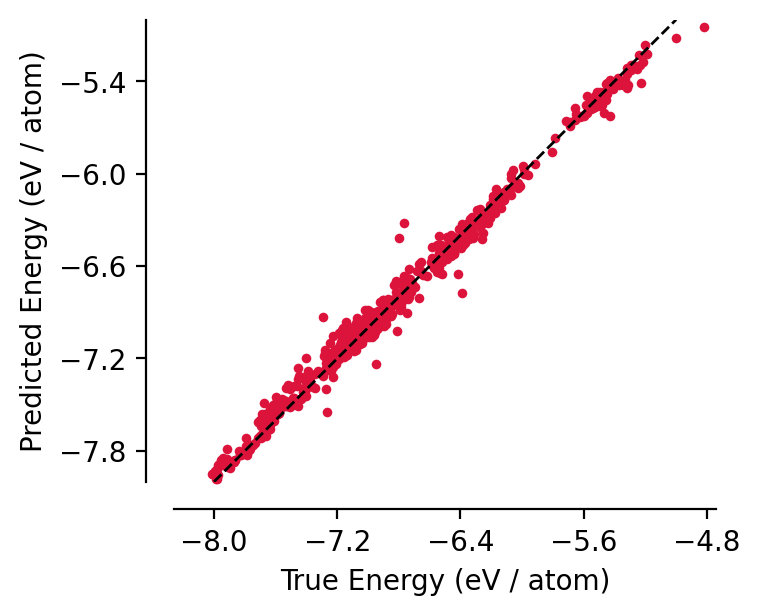

In [42]:
fine_tuned_model = load_model(
    "graph-pes-results/finetune-nequip-for-cgap20u/model.pt"
)
parity_plot(
    fine_tuned_model,
    cgap20_test_graphs,
    property="energy",
    transform=divide_per_atom,
    units="eV / atom",
    lw=0,
    s=12,
    color="crimson"
)
plt.xlim(-8, -5)
plt.ylim(-8, -5);